In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import v2 as T
from torchvision import models
from torchvision.models.resnet import ResNet18_Weights
from torchvision.models import vgg16, VGG16_Weights
from torch.optim.lr_scheduler import StepLR

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score

import matplotlib.pyplot as plt
import numpy as np

In [3]:
dataset_path = '/Users/sifatnawrinnova/Academic/Chalmers/Applied Machine Learning/PA5/a5_data'

train_path = f'{dataset_path}/train'
train_folder = ImageFolder(train_path, transform=transforms.ToTensor())
train_loader = DataLoader(train_folder, batch_size=8, shuffle=True)

val_path = f'{dataset_path}/val'
val_folder = ImageFolder(val_path, transform=transforms.ToTensor())
val_loader = DataLoader(val_folder, batch_size=8, shuffle=True)

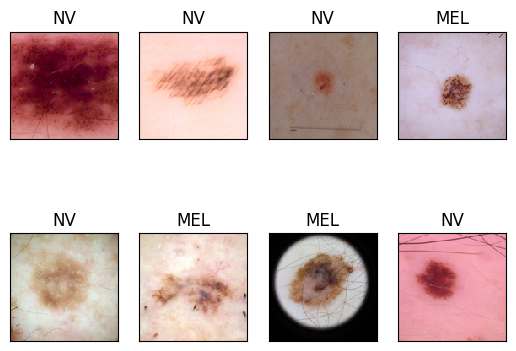

In [4]:
Xexamples, Yexamples = next(iter(train_loader))

for i in range(8):
    plt.subplot(2,4,i+1)
    img = Xexamples[i].numpy().transpose(1, 2, 0)
    plt.imshow(img, interpolation='none')
    plt.title('NV' if Yexamples[i] else 'MEL')
    plt.xticks([])
    plt.yticks([])

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_classifier(model, train_data, val_data, hyperparams):
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['lr'])

    loss_func = torch.nn.CrossEntropyLoss()

    acc_history = []

    for epoch in range(hyperparams['n_epochs']):
        model.train()
        loss_sum = 0

        for Xbatch, Ybatch in tqdm(train_data):
            Xbatch, Ybatch = Xbatch.to(device), Ybatch.to(device)

            outputs = model(Xbatch)
            loss = loss_func(outputs, Ybatch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()

        model.eval()
        with torch.no_grad():
            val_acc = predict_and_evaluate(model, val_data)

        mean_loss = loss_sum / len(train_data)

        acc_history.append(val_acc)

        print(f'Epoch {epoch+1}: loss = {mean_loss:.4f}, val acc = {val_acc:.4f}')

    return acc_history


def predict_and_evaluate(model, data):

    all_gold = []
    all_pred = []

    for Xbatch, Ybatch in data:
        Xbatch, Ybatch = Xbatch.to(device), Ybatch.to(device)
        outputs = model(Xbatch)
        predictions = outputs.argmax(dim=1)

        all_gold.extend(Ybatch.cpu().numpy())
        all_pred.extend(predictions.cpu().numpy())

    return accuracy_score(all_gold, all_pred)

In [27]:
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.num_flat_features = None
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        if self.num_flat_features is None:
            self.num_flat_features = x.nelement() // x.size(0)
            self.fc1 = nn.Linear(self.num_flat_features, 128).to(x.device)
        x = x.view(-1, self.num_flat_features)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_cnn = BaselineCNN()

In [28]:
train_data = train_loader
val_data = val_loader

hyperparams = {'lr': 1e-2,'n_epochs': 10}

history_cnn = train_classifier(model_cnn, train_data, val_data, hyperparams)

100%|██████████| 804/804 [00:31<00:00, 25.88it/s]


Epoch 1: loss = 0.5386, val acc = 0.6581


100%|██████████| 804/804 [00:27<00:00, 28.88it/s]


Epoch 2: loss = 0.5101, val acc = 0.7244


100%|██████████| 804/804 [00:27<00:00, 29.04it/s]


Epoch 3: loss = 0.4798, val acc = 0.7420


100%|██████████| 804/804 [00:27<00:00, 28.95it/s]


Epoch 4: loss = 0.4588, val acc = 0.7109


100%|██████████| 804/804 [00:27<00:00, 28.95it/s]


Epoch 5: loss = 0.4849, val acc = 0.7173


100%|██████████| 804/804 [00:27<00:00, 28.76it/s]


Epoch 6: loss = 0.4749, val acc = 0.7428


100%|██████████| 804/804 [00:27<00:00, 28.74it/s]


Epoch 7: loss = 0.5274, val acc = 0.7149


100%|██████████| 804/804 [00:28<00:00, 28.65it/s]


Epoch 8: loss = 0.5196, val acc = 0.7436


100%|██████████| 804/804 [00:28<00:00, 28.69it/s]


Epoch 9: loss = 0.4852, val acc = 0.7508


100%|██████████| 804/804 [00:28<00:00, 28.58it/s]


Epoch 10: loss = 0.4539, val acc = 0.7540


In [77]:
def calculate_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0

    for images, _ in loader:
        image_count_in_batch = images.size(0)
        images = images.view(image_count_in_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_batch

    mean /= total_images_count
    std /= total_images_count

    return mean, std

mean, std = calculate_mean_std(train_loader)

print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.6837, 0.5231, 0.5099])
Std: tensor([0.1297, 0.1499, 0.1633])


In [29]:
train_transforms = T.Compose([
    T.ToImage(),
    T.RandomResizedCrop(size=(224, 224), antialias=True),
    T.RandomHorizontalFlip(),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.6837, 0.5231, 0.5099], std=[0.1297, 0.1499, 0.1633]),
])

val_transforms = T.Compose([
    T.ToImage(),
    T.Resize(size=(256, 256), antialias=True),
    T.CenterCrop(size=(224, 224)),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.6837, 0.5231, 0.5099], std=[0.1297, 0.1499, 0.1633]),
])

In [30]:
train_dataset = ImageFolder(train_path, transform=train_transforms)
train_loadset = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = ImageFolder(val_path, transform=val_transforms)
val_loadset = DataLoader(val_dataset, batch_size=8, shuffle=False)

train_data1 = train_loadset
val_data1 = val_loadset

In [32]:
class CNNWithBatchNorm(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNWithBatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.num_flat_features = None
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        if self.num_flat_features is None:
            self.num_flat_features = x.nelement() // x.size(0)
            self.fc1 = nn.Linear(self.num_flat_features, 128).to(x.device)
        x = x.view(-1, self.num_flat_features)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_cnn_bn = CNNWithBatchNorm()

In [33]:
hyperparams = {'lr': 1e-3,'n_epochs': 10}

history_cnn_bn = train_classifier(model_cnn_bn, train_data1, val_data1, hyperparams)

100%|██████████| 804/804 [01:17<00:00, 10.37it/s]


Epoch 1: loss = 0.5140, val acc = 0.7604


100%|██████████| 804/804 [01:17<00:00, 10.39it/s]


Epoch 2: loss = 0.4756, val acc = 0.7612


100%|██████████| 804/804 [01:17<00:00, 10.40it/s]


Epoch 3: loss = 0.4659, val acc = 0.7796


100%|██████████| 804/804 [01:17<00:00, 10.33it/s]


Epoch 4: loss = 0.4607, val acc = 0.7835


100%|██████████| 804/804 [01:59<00:00,  6.76it/s]  


Epoch 5: loss = 0.4515, val acc = 0.8035


100%|██████████| 804/804 [01:19<00:00, 10.09it/s]


Epoch 6: loss = 0.4472, val acc = 0.8043


100%|██████████| 804/804 [01:20<00:00, 10.00it/s]


Epoch 7: loss = 0.4374, val acc = 0.8147


100%|██████████| 804/804 [01:19<00:00, 10.15it/s]


Epoch 8: loss = 0.4339, val acc = 0.7971


100%|██████████| 804/804 [01:19<00:00, 10.12it/s]


Epoch 9: loss = 0.4355, val acc = 0.7963


100%|██████████| 804/804 [01:19<00:00, 10.14it/s]


Epoch 10: loss = 0.4281, val acc = 0.7987


In [34]:
class CNNWithLayerNorm(nn.Module):
    def __init__(self, num_classes=2):
        super(CNNWithLayerNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.num_flat_features = None
        self.layer_norm = None
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))

        if self.num_flat_features is None:
            self.num_flat_features = x.nelement() // x.size(0)
            self.layer_norm = nn.LayerNorm(self.num_flat_features).to(x.device)
            self.fc1 = nn.Linear(self.num_flat_features, 128).to(x.device)

        x = x.view(-1, self.num_flat_features)

        x = self.layer_norm(x)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_cnn_ln = CNNWithLayerNorm()

In [35]:
hyperparams = {'lr': 1e-3,'n_epochs': 10}

history_cnn_ln = train_classifier(model_cnn_ln, train_data1, val_data1, hyperparams)

100%|██████████| 804/804 [01:10<00:00, 11.39it/s]


Epoch 1: loss = 0.5073, val acc = 0.7588


100%|██████████| 804/804 [01:10<00:00, 11.43it/s]


Epoch 2: loss = 0.4696, val acc = 0.7955


100%|██████████| 804/804 [01:10<00:00, 11.44it/s]


Epoch 3: loss = 0.4423, val acc = 0.7947


100%|██████████| 804/804 [01:10<00:00, 11.43it/s]


Epoch 4: loss = 0.4379, val acc = 0.7931


100%|██████████| 804/804 [15:02<00:00,  1.12s/it]  


Epoch 5: loss = 0.4288, val acc = 0.7947


100%|██████████| 804/804 [01:11<00:00, 11.24it/s]


Epoch 6: loss = 0.4204, val acc = 0.8211


100%|██████████| 804/804 [01:11<00:00, 11.23it/s]


Epoch 7: loss = 0.4171, val acc = 0.8139


100%|██████████| 804/804 [01:13<00:00, 11.00it/s]


Epoch 8: loss = 0.4117, val acc = 0.8195


100%|██████████| 804/804 [01:12<00:00, 11.14it/s]


Epoch 9: loss = 0.4029, val acc = 0.8251


100%|██████████| 804/804 [01:13<00:00, 11.00it/s]


Epoch 10: loss = 0.4013, val acc = 0.8131


In [43]:
class CNNWithGroupNorm(nn.Module):
    def __init__(self, num_classes=2, num_groups=8):
        super(CNNWithGroupNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.gn1 = nn.GroupNorm(num_groups=min(num_groups, 16), num_channels=16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.gn2 = nn.GroupNorm(num_groups=min(num_groups, 32), num_channels=32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.gn3 = nn.GroupNorm(num_groups=min(num_groups, 64), num_channels=64)
        self.pool = nn.MaxPool2d(2, 2)
        self.num_flat_features = None
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.gn1(self.conv1(x))))
        x = self.pool(self.relu(self.gn2(self.conv2(x))))
        x = self.pool(self.relu(self.gn3(self.conv3(x))))
        if self.num_flat_features is None:
            self.num_flat_features = x.nelement() // x.size(0)
            self.fc1 = nn.Linear(self.num_flat_features, 128).to(x.device)
        x = x.view(-1, self.num_flat_features)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_cnn_gn = CNNWithGroupNorm()

In [44]:
hyperparams = {'lr': 1e-3,'n_epochs': 10}

history_cnn_gn = train_classifier(model_cnn_gn, train_data1, val_data1, hyperparams)

100%|██████████| 804/804 [01:16<00:00, 10.58it/s]


Epoch 1: loss = 0.4999, val acc = 0.7891


100%|██████████| 804/804 [01:18<00:00, 10.21it/s]


Epoch 2: loss = 0.4524, val acc = 0.8099


100%|██████████| 804/804 [01:15<00:00, 10.59it/s]


Epoch 3: loss = 0.4309, val acc = 0.7971


100%|██████████| 804/804 [01:15<00:00, 10.60it/s]


Epoch 4: loss = 0.4140, val acc = 0.8179


100%|██████████| 804/804 [01:15<00:00, 10.60it/s]


Epoch 5: loss = 0.4045, val acc = 0.8139


100%|██████████| 804/804 [42:42<00:00,  3.19s/it]    


Epoch 6: loss = 0.3882, val acc = 0.8155


100%|██████████| 804/804 [01:23<00:00,  9.62it/s]


Epoch 7: loss = 0.3810, val acc = 0.8243


100%|██████████| 804/804 [01:20<00:00,  9.99it/s]


Epoch 8: loss = 0.3731, val acc = 0.8123


100%|██████████| 804/804 [01:22<00:00,  9.71it/s]


Epoch 9: loss = 0.3681, val acc = 0.8307


100%|██████████| 804/804 [01:20<00:00,  9.99it/s]


Epoch 10: loss = 0.3607, val acc = 0.8323


In [45]:
class ResNetTransfer(nn.Module):
    def __init__(self, num_classes=2, local_weights_path=None):
        super(ResNetTransfer, self).__init__()
        
        if local_weights_path:
            self.resnet = models.resnet18(weights=None)
            self.resnet.load_state_dict(torch.load(local_weights_path))
        else:
            self.resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        for param in self.resnet.parameters():
            param.requires_grad = False

        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

local_weights_path = '/Users/sifatnawrinnova/Academic/Chalmers/Applied Machine Learning/PA5/resnet18-f37072fd.pth'
resnet_model = ResNetTransfer(local_weights_path=local_weights_path)

In [46]:
hyperparams = {'lr': 1e-3,'n_epochs': 10}

history_cnn_resnet = train_classifier(resnet_model, train_data1, val_data1, hyperparams)

100%|██████████| 804/804 [01:38<00:00,  8.18it/s]


Epoch 1: loss = 0.5125, val acc = 0.8131


100%|██████████| 804/804 [01:34<00:00,  8.54it/s]


Epoch 2: loss = 0.4675, val acc = 0.8179


100%|██████████| 804/804 [33:39<00:00,  2.51s/it]    


Epoch 3: loss = 0.4630, val acc = 0.8419


100%|██████████| 804/804 [17:45<00:00,  1.33s/it]    


Epoch 4: loss = 0.4586, val acc = 0.7923


100%|██████████| 804/804 [01:37<00:00,  8.22it/s]


Epoch 5: loss = 0.4506, val acc = 0.8219


100%|██████████| 804/804 [01:35<00:00,  8.42it/s]


Epoch 6: loss = 0.4880, val acc = 0.8331


100%|██████████| 804/804 [01:35<00:00,  8.40it/s]


Epoch 7: loss = 0.4775, val acc = 0.8339


100%|██████████| 804/804 [01:33<00:00,  8.56it/s]


Epoch 8: loss = 0.4690, val acc = 0.8442


100%|██████████| 804/804 [01:34<00:00,  8.51it/s]


Epoch 9: loss = 0.4741, val acc = 0.8482


100%|██████████| 804/804 [01:34<00:00,  8.49it/s]


Epoch 10: loss = 0.4543, val acc = 0.8331


In [47]:
vggmodel = models.vgg16()

weights_path = '/Users/sifatnawrinnova/Academic/Chalmers/Applied Machine Learning/PA5/vgg16-397923af.pth'
vggmodel.load_state_dict(torch.load(weights_path))

vggmodel.eval()

weights_id = VGG16_Weights.IMAGENET1K_V1
vggtransforms = weights_id.transforms()

train_dataset2 = ImageFolder(train_path, transform=vggtransforms)
train_loadset2 = DataLoader(train_dataset2, batch_size=8, shuffle=True)

val_dataset2 = ImageFolder(val_path, transform=vggtransforms)
val_loadset2 = DataLoader(val_dataset2, batch_size=8, shuffle=False)

train_data2 = train_loadset2
val_data2 = val_loadset2

for param in vggmodel.features.parameters():
    param.requires_grad = False

num_features = vggmodel.classifier[6].in_features
vggmodel.classifier[6] = nn.Linear(num_features, 2)

In [48]:
hyperparams = {'lr': 1e-3,'n_epochs': 10}

history_vgg16_model = train_classifier(vggmodel, train_data2, val_data2, hyperparams)

100%|██████████| 804/804 [09:36<00:00,  1.40it/s]


Epoch 1: loss = 0.9462, val acc = 0.8275


100%|██████████| 804/804 [09:34<00:00,  1.40it/s]


Epoch 2: loss = 0.6088, val acc = 0.7356


100%|██████████| 804/804 [09:22<00:00,  1.43it/s]


Epoch 3: loss = 0.4842, val acc = 0.8371


100%|██████████| 804/804 [16:28<00:00,  1.23s/it]   


Epoch 4: loss = 0.4756, val acc = 0.8538


100%|██████████| 804/804 [09:32<00:00,  1.40it/s]


Epoch 5: loss = 0.4924, val acc = 0.8466


100%|██████████| 804/804 [09:32<00:00,  1.41it/s]


Epoch 6: loss = 0.4149, val acc = 0.8403


100%|██████████| 804/804 [09:38<00:00,  1.39it/s]


Epoch 7: loss = 0.4219, val acc = 0.8450


100%|██████████| 804/804 [09:40<00:00,  1.39it/s]


Epoch 8: loss = 0.5204, val acc = 0.8618


100%|██████████| 804/804 [09:35<00:00,  1.40it/s]


Epoch 9: loss = 0.3361, val acc = 0.8586


100%|██████████| 804/804 [09:40<00:00,  1.39it/s]


Epoch 10: loss = 0.2605, val acc = 0.8538


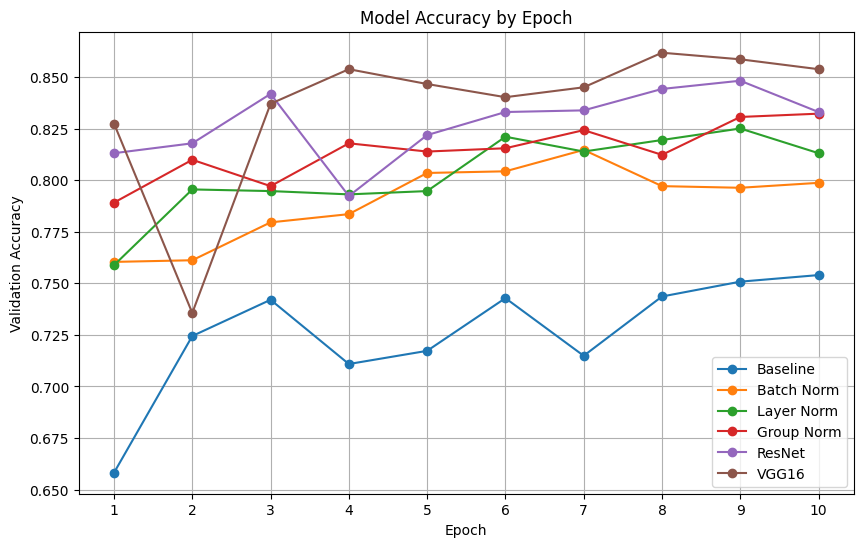

In [49]:
epochs = range(1, len(history_cnn) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, history_cnn, label='Baseline', marker='o')
plt.plot(epochs, history_cnn_bn, label='Batch Norm', marker='o')
plt.plot(epochs, history_cnn_ln, label='Layer Norm', marker='o')
plt.plot(epochs, history_cnn_gn, label='Group Norm', marker='o')
plt.plot(epochs, history_cnn_resnet, label='ResNet', marker='o')
plt.plot(epochs, history_vgg16_model, label='VGG16', marker='o')

plt.title('Model Accuracy by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(epochs)

plt.show()

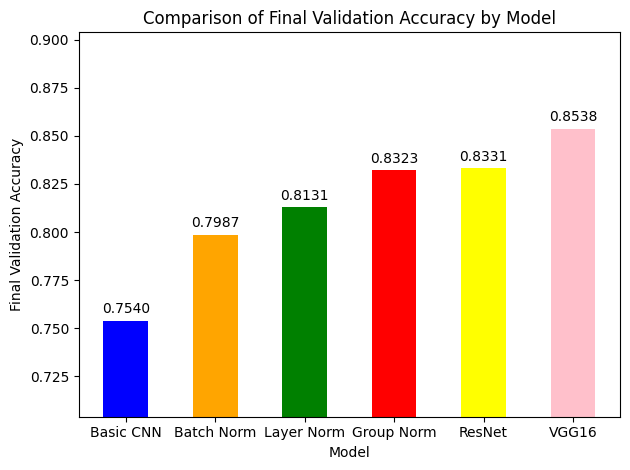

In [50]:
final_acc_baseline = history_cnn[-1]
final_acc_bn = history_cnn_bn[-1]
final_acc_ln = history_cnn_ln[-1]
final_acc_gn = history_cnn_gn[-1]
final_acc_resnet = history_cnn_resnet[-1]
final_acc_vgg16 = history_vgg16_model[-1]

models = ['Basic CNN', 'Batch Norm', 'Layer Norm', 'Group Norm', 'ResNet', 'VGG16']
accuracies = [final_acc_baseline, final_acc_bn, final_acc_ln, final_acc_gn, final_acc_resnet, final_acc_vgg16]

x = np.arange(len(models))
width = 0.50

fig, ax = plt.subplots()
bars = ax.bar(x, accuracies, width, color=['blue', 'orange', 'green', 'red', 'yellow', 'pink'])

ax.set_xlabel('Model')
ax.set_ylabel('Final Validation Accuracy')
ax.set_title('Comparison of Final Validation Accuracy by Model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim([min(accuracies) - 0.05, max(accuracies) + 0.05])

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [75]:
test_dataset = ImageFolder(root='/Users/sifatnawrinnova/Academic/Chalmers/Applied Machine Learning/PA5/a5_data_test/test', transform=vggtransforms)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [76]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = vggmodel(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy:.2f}%')

Accuracy of the model on the test images: 85.58%


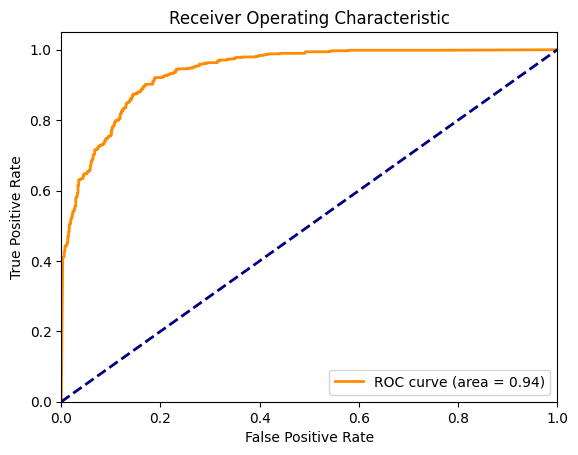

ROC AUC score: 0.94


In [71]:
vggmodel.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vggmodel.to(device)

true_labels = []
pred_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = vggmodel(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        pred_probs_batch = probs[:, 1]
        true_labels.append(labels.cpu().numpy())
        pred_probs.append(pred_probs_batch.cpu().numpy())

true_labels = np.concatenate(true_labels)
pred_probs = np.concatenate(pred_probs)

fpr, tpr, _ = roc_curve(true_labels, pred_probs)
roc_auc = roc_auc_score(true_labels, pred_probs)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f'ROC AUC score: {roc_auc:0.2f}')

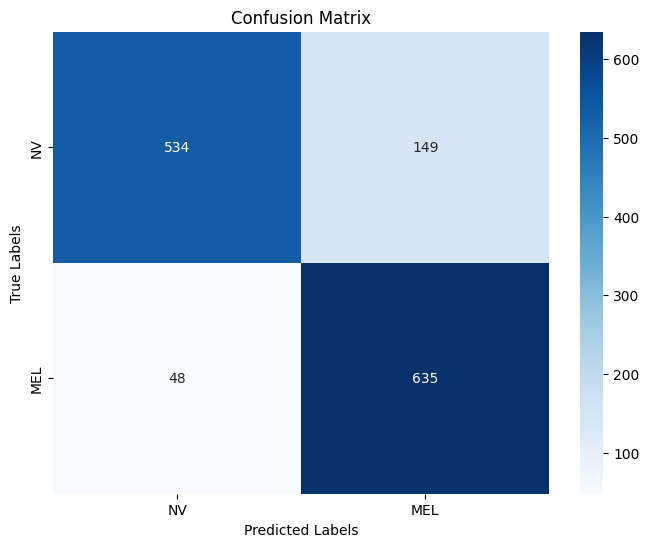

In [72]:
threshold = 0.5

pred_classes = (pred_probs >= threshold).astype(int)

cm = confusion_matrix(true_labels, pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NV', 'MEL'], yticklabels=['NV', 'MEL'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [58]:
vggmodel.eval()

predictions = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = vggmodel(inputs)
        _, preds = torch.max(outputs, 1)
        for pred in preds:
            predictions.append('MEL' if pred.item() == 0 else 'NV')

output_file_path = '/Users/sifatnawrinnova/Academic/Chalmers/Applied Machine Learning/PA5/predictions.txt'

with open(output_file_path, 'w') as f:
    for pred in predictions:
        f.write(f"{pred}\n")

with open(output_file_path) as f:
    guesses = [line.strip() for line in f]
    assert(len(guesses) == 1366)
    assert(sorted(set(guesses)) == ['MEL', 'NV'])
